In [ ]:
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
from google.colab import files
from numpy import diff
from scipy import integrate
Lx,Ly = 2000,2000                                   # Space in x and y direction, 2000km
a = 180                                            # a = 180km
b = 600                                             # b = 600km
Nx = 101                                            # Grid points in x direction
Ny = 101                                            # Grid points in y direction
tol = 2e-8                                          # Tolerance = 10^-8
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
x0_1,y0_1 = Lx/2 + b/2,Ly/2                           # Initial position for first vortex
x0_2,y0_2 = Lx/2 - b/2,Ly/2                           # Initial position for second vortex
T_tot = 20 * 60 * 60 * 24                           # 20 days to seconds
tau = 8 * 1e-5                                      # Tau/pi*a^2 = 8 x 10 ^ -5
beta = 2e-14
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny)
x_mesh,y_mesh = np.meshgrid(x,y)

vort_function = lambda x, y, x0, y0: tau * np.exp(-1*((((x - x0) ** 2) / (a ** 2)) + (((y - y0) ** 2) / (a ** 2))))


In [ ]:
def SOR_opt(dx,dy):
  sigma = (1/(1+(dx/dy)**2))*((math.cos(math.pi/Nx)+((dx/dy)**2))*(math.cos(math.pi/Ny)))
  return 2/(1+math.sqrt(1-sigma**2))

print(SOR_opt(dx,dy))

1.9266263179388756


In [ ]:
def plot_cmap(np_array,Title):
  plt.figure()
  plt.imshow(np_array,cmap = 'bwr',vmin=np.min(np_array), vmax=np.max(np_array))
  plt.colorbar()
  plt.title(Title)

In [ ]:

vort1 = np.zeros([Ny,Nx])
vort2 = np.zeros([Ny,Nx])
vort1[0:Ny,0:Nx] = vort_function(x_mesh,y_mesh,x0_1,y0_1)
vort2[0:Ny,0:Nx] = vort_function(x_mesh,y_mesh,x0_2,y0_2)

vort_super = vort1+vort2


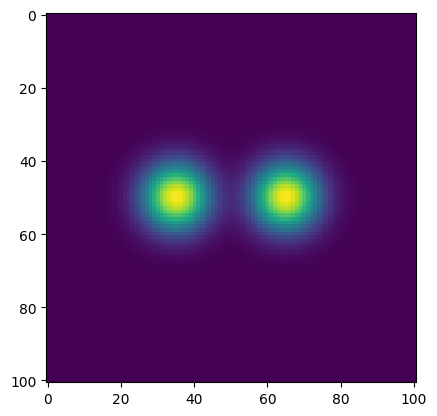

In [ ]:

fig, ax = plt.subplots()
im = ax.imshow(vort_super)

def animate(frame, u,t_delta):
    ax.clear()
    ax.imshow(u[frame, :, :], origin='lower', extent=[0, Lx, 0, Ly])
    ax.set_title("Vorticity at time step: {0:.2f} seconds".format(frame * t_delta))
    ax.set_xlim(0,Lx)
    ax.set_ylim(0,Ly)
    ax.set_xlabel("X in km")
    ax.set_ylabel("Y in km")
    return [im]

In [ ]:


def infinite_norm(matrix):
    return np.max(np.abs(matrix))

def one_norm(matrix):
    return np.sum(np.abs(matrix))

e_dxdy = 2/dx/dx + 2/dy/dy

def error(psi,vort,res):
  psi_one_norm = one_norm(psi)
  res_inf_norm = infinite_norm(res)
  vort_inf_norm = infinite_norm(vort)

  EPS = res_inf_norm /((e_dxdy)*psi_one_norm + vort_inf_norm)
  return EPS

In [ ]:
def SOR(vort):
  psi = np.zeros([Ny,Nx])
  residual = np.zeros([Ny,Nx])
  u = np.zeros([Ny,Nx])
  v = np.zeros([Ny,Nx])
  coef = SOR_opt(dx,dy)

  residual[1:Nx-1,1:Ny-1] =  1/dx/dx *(psi[1:Ny-1,0:Nx-2] - 2*psi[1:Ny-1,1:Nx-1] + psi[1:Ny-1,2:Nx]) \
  + 1/dy/dy * (psi[0:Ny-2,1:Nx-1] - 2*psi[1:Ny-1,1:Nx-1] + psi[2:Ny,1:Nx-1]) - vort[1:Ny-1,1:Nx-1]

  residual[0,:] = 0
  residual[:,0] = 0
  residual[Ny-1,:] = 0
  residual[:,Nx-1] = 0

  EPS = error(psi,vort,residual)
  num_iterations = 0
  EPS_arr = []
  EPS_arr.append(EPS)
  while(EPS >= tol):
    for j in range(1,Ny-1):
      for i in range(1,Nx-1):
        residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
        + 1/dy/dy *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) - vort[j,i]

        psi[j,i] = psi[j,i] + coef/(e_dxdy) * residual[j,i]  #Remember to subsititute 1 with optimal value of sigma

    # print(EPS)
    EPS = error(psi,vort,residual)
    num_iterations += 1
    EPS_arr.append(EPS)
  print(num_iterations)
  # print(psi.shape)

  #calculate u and v by differentating psi with respect to dy and dx
  # u, v = np.gradient(psi, dy, dx)
  u = np.gradient(psi,dy,axis = 0)
  v = np.gradient(psi,dx,axis = 1)
  # Multiply d_psi_dy by -1 to get the negative of the derivative
  u *= -1


  # Compute the Laplacian (∇²psi) using numerical differentiation
  d2_psi_dx2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dx**2
  d2_psi_dy2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dy**2

  laplacian_psi = d2_psi_dx2 + d2_psi_dy2

  return psi,u,v,num_iterations,laplacian_psi

In [ ]:
def SOR_psi(psi,vort):
  residual = np.zeros([Ny,Nx])
  u = np.zeros([Ny,Nx])
  v = np.zeros([Ny,Nx])
  coef = SOR_opt(dx,dy)

  residual[1:Nx-1,1:Ny-1] =  1/dx/dx *(psi[1:Ny-1,0:Nx-2] - 2*psi[1:Ny-1,1:Nx-1] + psi[1:Ny-1,2:Nx]) \
  + 1/dy/dy * (psi[0:Ny-2,1:Nx-1] - 2*psi[1:Ny-1,1:Nx-1] + psi[2:Ny,1:Nx-1]) - vort[1:Ny-1,1:Nx-1]

  residual[0,:] = 0
  residual[:,0] = 0
  residual[Ny-1,:] = 0
  residual[:,Nx-1] = 0

  EPS = error(psi,vort,residual)
  num_iterations = 0
  EPS_arr = []
  EPS_arr.append(EPS)
  while(EPS >= tol):
    for j in range(1,Ny-1):
      for i in range(1,Nx-1):
        residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
        + 1/dy/dy *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) - vort[j,i]

        psi[j,i] = psi[j,i] + coef/(e_dxdy) * residual[j,i]  #Remember to subsititute 1 with optimal value of sigma

    # print(EPS)
    EPS = error(psi,vort,residual)
    num_iterations += 1
    EPS_arr.append(EPS)
  print(num_iterations)
  # print(psi.shape)

  #calculate u and v by differentating psi with respect to dy and dx
  # u, v = np.gradient(psi, dy, dx)
  u = np.gradient(psi,dy,axis = 0)
  v = np.gradient(psi,dx,axis = 1)
  # Multiply d_psi_dy by -1 to get the negative of the derivative
  u *= -1


  # Compute the Laplacian (∇²psi) using numerical differentiation
  d2_psi_dx2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dx**2
  d2_psi_dy2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dy**2

  laplacian_psi = d2_psi_dx2 + d2_psi_dy2

  return psi,u,v,num_iterations,laplacian_psi

In [ ]:

psi,u,v,num_iterations,laplacian_psi = SOR(vort_super)
print(psi[0,:])
Mg = np.sqrt(u**2+v**2)

ktot = lambda y,x :0.5*np.sqrt(u**2+v**2)**2
def ktot(u,v):
  return 0.5*np.sqrt(u**2+v**2)**2

def double_Integral(xmin, xmax, ymin, ymax, nx, ny, A):

    dS = ((xmax-xmin)/(nx-1)) * ((ymax-ymin)/(ny-1))

    A_Internal = A[1:-1, 1:-1]

    # sides: up, down, left, right
    (A_u, A_d, A_l, A_r) = (A[0, 1:-1], A[-1, 1:-1], A[1:-1, 0], A[1:-1, -1])

    # corners
    (A_ul, A_ur, A_dl, A_dr) = (A[0, 0], A[0, -1], A[-1, 0], A[-1, -1])

    return dS * (np.sum(A_Internal)\
                + 0.5 * (np.sum(A_u) + np.sum(A_d) + np.sum(A_l) + np.sum(A_r))\
                + 0.25 * (A_ul + A_ur + A_dl + A_dr))

k = ktot(u,v)
print(k.shape)

k_energy = double_Integral(0,Lx,0,Ly,Nx,Ny,k)
print(k_energy)

def enstrophy(vort):
  vort = np.square(vort)
  e = double_Integral(0,Lx,0,Ly,Nx,Ny,vort)
  return e
# Derived from doing max(u/dx + v/dy)
delta_t = 2000
def courant_max(u,v,delta_t):
  return np.max(u*delta_t/dx + v*delta_t/dy)

cour_max = courant_max(u,v,2000)


#We defined
print(cour_max)
print(delta_t)

print(enstrophy(vort_super))
# E_tot =



184
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
(101, 101)
24.2220088905928
0.8530659979680177
2000
0.0006539590701871214


184
Total Kinetic Energy:24.2220088905928
Total Enstrophy:0.0006539590701871214
Von Neumman:0.8530659979680177
52
Total Kinetic Energy:24.33398564313301
Total Enstrophy:0.000655612679630543
Von Neumman:0.8519221967926127
0
Total Kinetic Energy:24.33398564313301
Von Neumman:0.8519221967926127
1
51
Total Kinetic Energy:24.360265511004908
Von Neumman:0.8489037395840904
2
0
Total Kinetic Energy:24.360265511004908
Von Neumman:0.8489037395840904
3
52
Total Kinetic Energy:24.37284595063824
Von Neumman:0.8462529916940609
4
0
Total Kinetic Energy:24.37284595063824
Von Neumman:0.8462529916940609
5
53
Total Kinetic Energy:24.383057139017545
Von Neumman:0.843051416738283
6
0
Total Kinetic Energy:24.383057139017545
Von Neumman:0.843051416738283
7
53
Total Kinetic Energy:24.3927476594409
Von Neumman:0.8386082490634916
8
0
Total Kinetic Energy:24.3927476594409
Von Neumman:0.8386082490634916
9
53
Total Kinetic Energy:24.402261506709277
Von Neumman:0.8354098375004448
10
28
Total Kinetic Energy:24.29120

KeyboardInterrupt: ignored

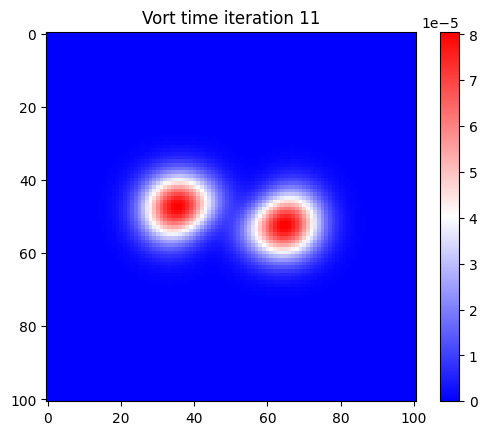

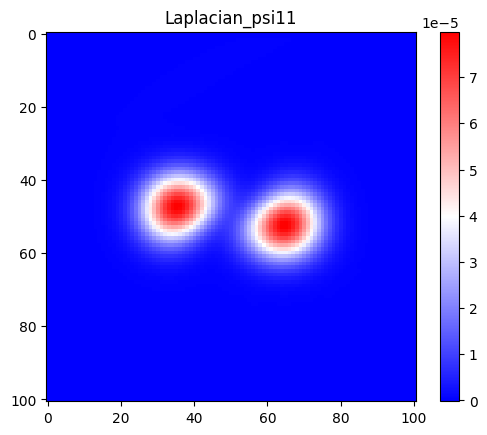

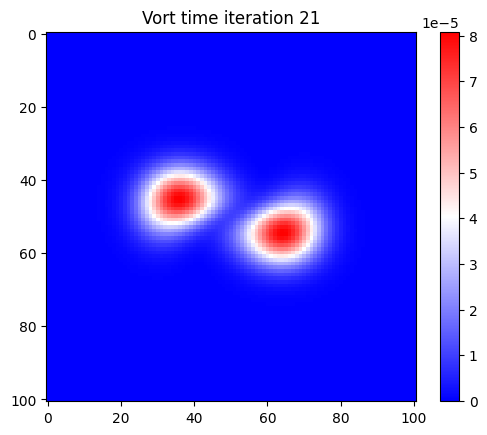

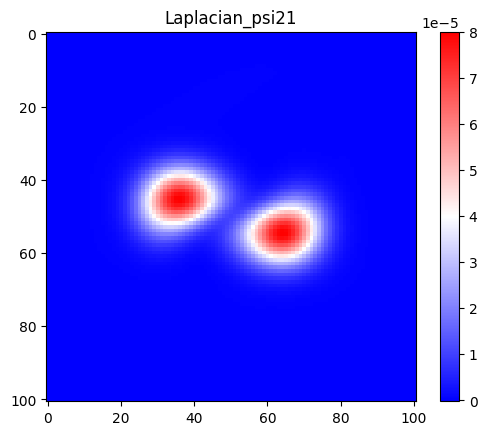

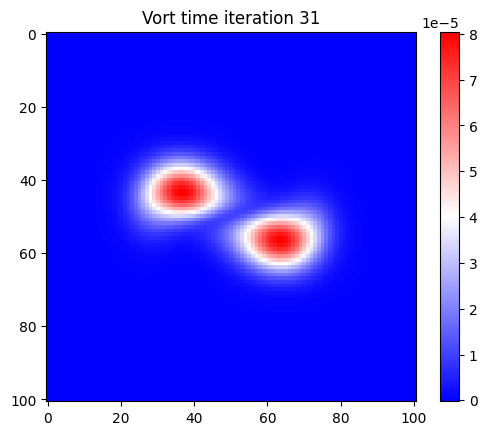

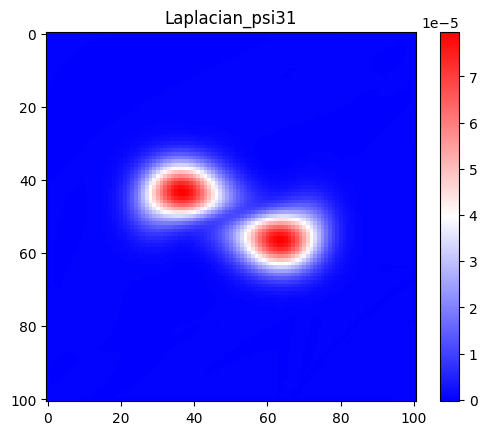

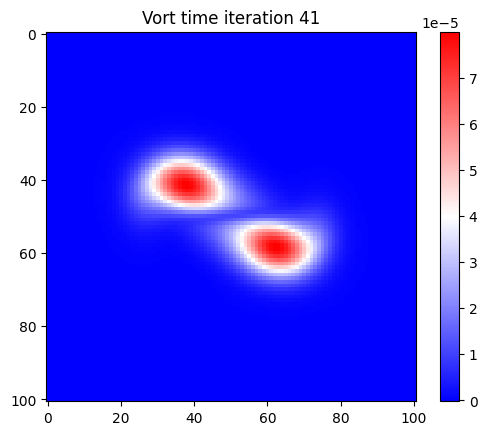

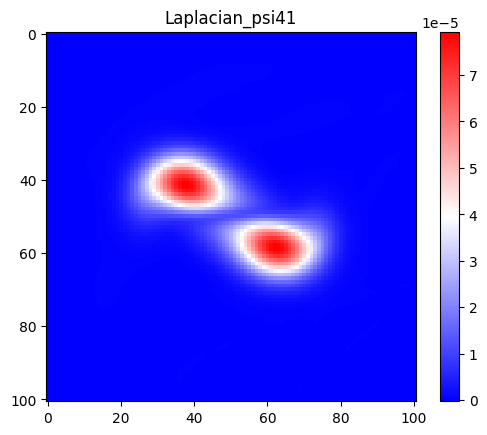

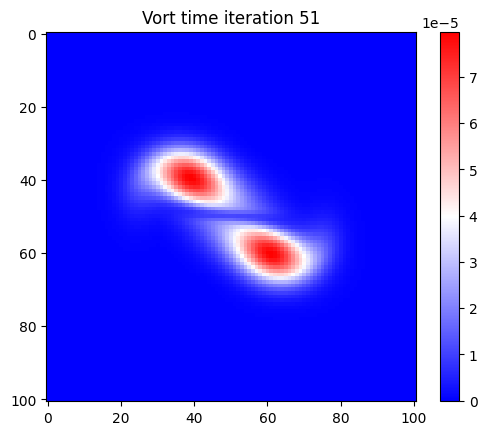

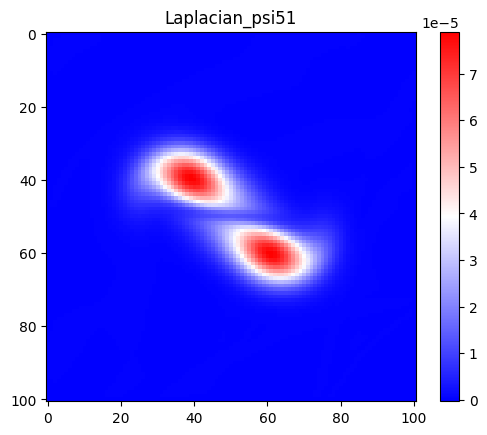

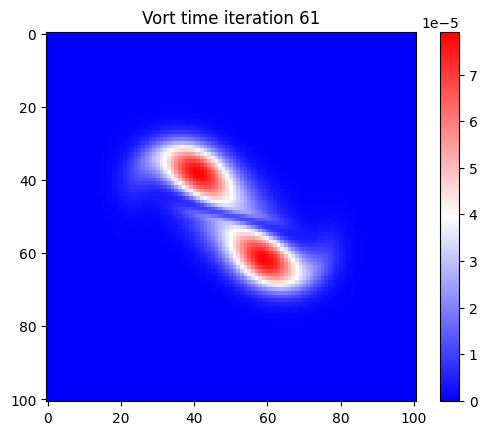

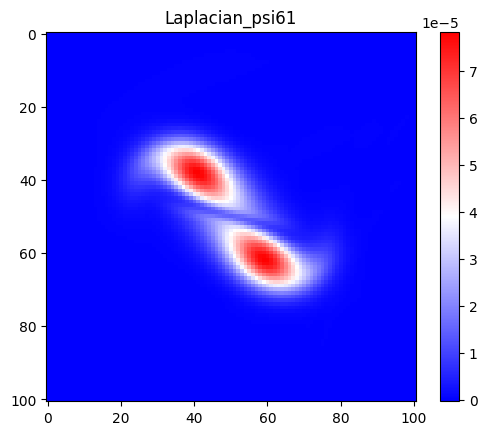

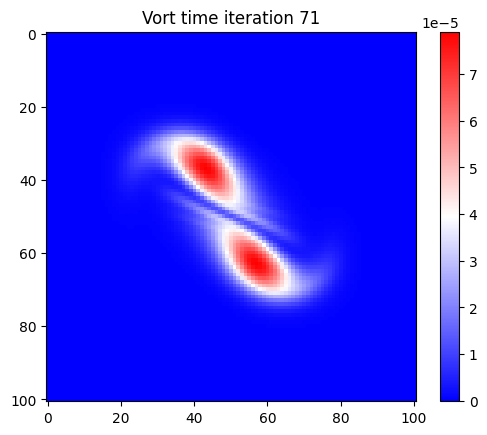

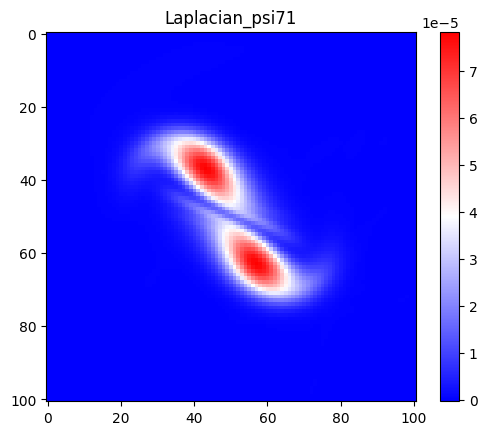

In [ ]:

def Two_D_advection(t_delta,init_vort):
  t_steps = int(T_tot/t_delta)
  psi,u,v,num_iterations,laplacian_psi=SOR(init_vort)
  vort = np.zeros([t_steps,Ny,Nx])
  vort[0,:,:] = init_vort

  k_energy_arr = []
  Ens_arr = []
  C_max_arr = []
  num_iterations_arr = []


  #Append num_iterations
  num_iterations_arr.append(num_iterations)

  # Calculate kinetic energy
  k_num = ktot(u,v)
  k_tot = double_Integral(0,Lx,0,Ly,Nx,Ny,k_num)
  k_energy_arr.append(k_tot)
  print("Total Kinetic Energy:{}".format(k_tot))

  #Calculate Enstrophy
  Ens_tot = enstrophy(vort[0,:,:])
  Ens_arr.append(Ens_tot)
  print("Total Enstrophy:{}".format(Ens_tot))

  #Calculate Von Neumann
  C_max = courant_max(u,v,t_delta)
  C_max_arr.append(C_max)
  print("Von Neumman:{}".format(C_max))

  #Calculate new vorticity using FTCS for first time step using implied loops from 1 to Nx-1 and 1 to Ny-1 grid points

  J = (1/(4*dx*dy))*((psi[1:Ny-1,2:Ny] - psi[1:Ny-1,0:Nx-2]) * (vort[0,2:Ny,1:Nx-1] - vort[0,0:Ny-2,1:Nx-1])
  - (psi[2:Ny,1:Nx-1] - psi[0:Ny-2,1:Nx-1]) * (vort[0,1:Ny-1,2:Nx] - vort[0,1:Ny-1,0:Nx-2]))

  J_hat = (1/(4*dx*dy))* (((psi[1:Ny-1,2:Nx])*(vort[0,2:Ny,2:Nx] - vort[0,0:Ny-2,2:Nx])) \
  - ((psi[1:Ny-1,0:Nx-2])*(vort[0,2:Ny,0:Nx-2] - vort[0,0:Ny-2,0:Nx-2]))  \
  - ((psi[2:Ny,1:Nx-1])*(vort[0,2:Ny,2:Nx] - vort[0,2:Ny,0:Nx-2]))  \
  + ((psi[0:Ny-2,1:Nx-1])*(vort[0,0:Ny-2,2:Nx] - vort[0,0:Ny-2,0:Nx-2])))

  J_tilda = (1/(4*dx*dy))* (((vort[0,2:Ny,1:Nx-1])*(psi[2:Ny,2:Nx] - psi[2:Ny,0:Nx-2])) \
  - ((vort[0,0:Ny-2,1:Nx-1])*(psi[0:Ny-2,2:Nx] - psi[0:Ny-2,0:Nx-2]))  \
  - ((vort[0,1:Ny-1,2:Nx])*(psi[2:Ny,2:Nx] - psi[0:Ny-2,2:Nx]))  \
  + ((vort[0,1:Ny-1,0:Nx-2])*(psi[2:Ny,0:Nx-2] - psi[0:Ny-2,0:Nx-2])))

  # print(v)
  vort[1,1:Ny-1,1:Nx-1] = vort[0,1:Ny-1,1:Nx-1] - (2*t_delta*(((J+J_hat+J_tilda)/3)))
  # vort[1,1:Ny-1,1:Nx-1] = vort[0,1:Ny-1,1:Nx-1] - (2*t_delta*(((J+J_hat+J_tilda)/3) + beta * v[1:Ny-1,1:Nx-1]))

  #Apply boundary conditions for the new vorticity field
  vort[1,:,0] = 0
  vort[1,0,:] = 0
  vort[1,:,Nx-1] = 0
  vort[1,Ny-1,:] = 0

  #Use the poisson solver again to compute psi,u,v
  psi,u,v,num_iterations,laplacian_psi = SOR_psi(psi,vort[1,:,:])


  #Append num_iterations
  num_iterations_arr.append(num_iterations)

  # Calculate kinetic energy
  k_num = ktot(u,v)
  k_tot = double_Integral(0,Lx,0,Ly,Nx,Ny,k_num)
  k_energy_arr.append(k_tot)
  print("Total Kinetic Energy:{}".format(k_tot))

  #Calculate Enstrophy
  Ens_tot = enstrophy(vort[1,:,:])
  Ens_arr.append(Ens_tot)
  print("Total Enstrophy:{}".format(Ens_tot))

  #Calculate Von Neumann
  C_max = courant_max(u,v,t_delta)
  C_max_arr.append(C_max)
  print("Von Neumman:{}".format(C_max))



  #Calculate new vorticity using CTCS for every time step using implied loops from 1 to Nx-1 and 1 to Ny-1 grid points
  for n in range(1,t_steps-1):
    J = (1/(4*dx*dy))*((psi[1:Ny-1,2:Nx] - psi[1:Ny-1,0:Nx-2]) * (vort[n,2:Ny,1:Nx-1] - vort[n,0:Ny-2,1:Nx-1]) \
    - (psi[2:Ny,1:Nx-1] - psi[0:Ny-2,1:Nx-1]) * (vort[n,1:Ny-1,2:Nx] - vort[n,1:Ny-1,0:Nx-2]))

    J_hat = (1/(4*dx*dy))* \
    (((psi[1:Ny-1,2:Nx])*(vort[n,2:Ny,2:Nx] - vort[n,0:Ny-2,2:Nx])) \
    - ((psi[1:Ny-1,0:Nx-2])*(vort[n,2:Ny,0:Nx-2] - vort[n,0:Ny-2,0:Nx-2]))  \
    - ((psi[2:Ny,1:Nx-1])*(vort[n,2:Ny,2:Nx] - vort[n,2:Ny,0:Nx-2]))  \
    + ((psi[0:Ny-2,1:Nx-1])*(vort[n,0:Ny-2,2:Nx] - vort[n,0:Ny-2,0:Nx-2])))

    J_tilda = (1/(4*dx*dy))* \
    (((vort[n,2:Ny,1:Nx-1])*(psi[2:Ny,2:Nx] - psi[2:Ny,0:Nx-2])) \
    - ((vort[n,0:Ny-2,1:Nx-1])*(psi[0:Ny-2,2:Nx] - psi[0:Ny-2,0:Nx-2]))  \
    - ((vort[n,1:Ny-1,2:Nx])*(psi[2:Ny,2:Nx] - psi[0:Ny-2,2:Nx]))  \
    + ((vort[n,1:Ny-1,0:Nx-2])*(psi[2:Ny,0:Nx-2] - psi[0:Ny-2,0:Nx-2])))

    vort[n+1,1:Ny-1,1:Nx-1] = vort[n-1,1:Ny-1,1:Nx-1] - (2*t_delta*(((J+J_hat+J_tilda)/3)))
    # vort[n+1,1:Ny-1,1:Nx-1] = vort[n-1,1:Ny-1,1:Nx-1] - (2*t_delta*(((J+J_hat+J_tilda)/3) + beta * v[1:Ny-1,1:Nx-1]))

    # vort[n+1,1:Ny-1,1:Nx-1] = vort[n-1,1:Ny-1,1:Nx-1] - (2*t_delta*(J))




    # temp_vort = vort[n-1, 1:Ny-1, 1:Nx-1]
    # temp_psi_x = psi[1:Ny-1, 2:Nx] - psi[1:Ny-1, 0:Nx-2]
    # temp_psi_y = psi[2:Ny, 1:Nx-1] - psi[0:Ny-2, 1:Nx-1]
    # temp_vort_x = vort[n, 2:Ny, 1:Nx-1] - vort[n, 0:Ny-2, 1:Nx-1]
    # temp_vort_y = vort[n, 1:Ny-1, 2:Nx] - vort[n, 1:Ny-1, 0:Nx-2]

    # vort[n+1, 1:Ny-1, 1:Nx-1] = temp_vort - (2*t_delta*1/(4*dx*dy)) \
    #      *((temp_psi_x) * (temp_vort_x) - (temp_psi_y) * (temp_vort_y))

    # vort[n+1,1:Ny-1,1:Nx-1] = vort[n-1,1:Ny-1,1:Nx-1] - 2 *t_delta *(1/(4*dx*dy)) \
    # * ((psi[1:Ny-1,2:Nx] - psi[1:Ny-1,0:Nx-2]) * (vort[n,2:Ny,1:Nx-1] - vort[n,0:Ny-2,1:Nx-1]) - \
    # (psi[2:Ny,1:Nx-1] - psi[0:Ny-2,1:Nx-1]) * (vort[n,1:Ny-1,2:Nx] - vort[n,1:Ny-1,0:Nx-2]))

    #Apply boundary conditions for the new vorticity field
    vort[n+1,:,0] = 0
    vort[n+1,0,:] = 0
    vort[n+1,:,Nx-1] = 0
    vort[n+1,Ny-1,:] = 0

    #Use the poisson solver again to compute psi,u,v
    psi,u,v,num_iterations,laplacian_psi = SOR_psi(psi,vort[n+1,:,:])

    #Append num_iterations
    num_iterations_arr.append(num_iterations)


    #   #Calculate kinetic energy
    k_num = ktot(u,v)
    k_tot = double_Integral(0,Lx,0,Ly,Nx,Ny,k_num)
    k_energy_arr.append(k_tot)
    print("Total Kinetic Energy:{}".format(k_tot))

    #Calculate Enstrophy
    Ens_tot = enstrophy(vort[n+1,:,:])
    Ens_arr.append(Ens_tot)
    # print("Total Enstrophy:{}".format(Ens_tot))

    #Calculate Von Neumann
    C_max = courant_max(u,v,t_delta)
    C_max_arr.append(C_max)
    print("Von Neumman:{}".format(C_max))

    if(n%10 == 0):
      plot_cmap(vort[n+1,:,:],"Vort time iteration {}".format(n+1))
      plot_cmap(laplacian_psi,"Laplacian_psi{}".format(n+1))
    print(n)
  #Create animation
  anim = animation.FuncAnimation(fig, animate, frames=t_steps,fargs=(vort,t_delta),interval=50, blit=True)
  plt.show()
  anim.save('RunA_Jacobian_switch_sign.mp4',writer = 'ffmpeg')
  files.download('RunA_Jacobian_switch_sign.mp4')
  return vort,k_energy_arr,C_max_arr,Ens_arr,num_iterations_arr


vort,k_energy_arr,C_max_arr,Ens_arr,num_iterations_arr = Two_D_advection(delta_t,vort_super)


In [ ]:
#vort,k_energy_arr,C_max_arr,Ens_arr,num_iterations_arr
plt.plot(num_iterations_arr)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Number of iterations")
plt.title("Time step vs.  Iterations")
plt.show()

In [ ]:
plt.plot(k_energy_arr)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Kinetic Energy")
plt.title("Time step vs.  Kinetic Energy")
plt.show()

In [ ]:

plt.plot(C_max_arr)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Von Neumann")
plt.title("Time step vs.  Von Neumann")
plt.show()

In [ ]:
plt.plot(Ens_arr)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Enstrophy")
plt.title("Time step vs.  Enstrophy")
plt.show()

In [ ]:
# iter_arr = np.linspace(0,num_iterations,num_iterations)
# plt.figure()
# plt.plot(iter_arr,EPS_arr)
# plt.title('EPS vs Number of Iterations')
# plt.show()
# plot_cmap(vort_super,'Vorticity')
# plot_cmap(psi,'Streamfunction ψ')
# plot_cmap(u,'velocity U(-dψ/dy)')
# plot_cmap(v,'velocity V(dψ/dx)')
# plot_cmap(laplacian_psi,'Laplacian ∇2ψ(x, y)')